In [1]:
# Standard libraries
import pandas as pd
import numpy as np

from scipy.linalg import pinv
from scipy.stats import probplot # for QQ-plots
import statsmodels.formula.api as smf

# For data transformations
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import \
	StandardScaler, \
	OneHotEncoder, \
	MinMaxScaler, \
	PowerTransformer
from sklearn.compose import ColumnTransformer

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import \
	calculate_bartlett_sphericity, \
	calculate_kmo

# Custom tools for working with CBS data
import cbspython as cbs		

# My own collection of hacked-together tools for doing stats, generating 
# figures, manipulating dataframes, etc.
from wildpython import \
	wild_plots as wp, \
	wild_statsmodels as ws, \
	wild_sklearn as wsk, \
	wild_colors as wc, \
	chord_plot

# Helper packages that load parse and load the study data.
from cbsdata.covid_brain_study import CovidBrainStudy as CC
from cbsdata.sleep_study import SleepStudy as SS

# Plotly for plotting
import plotly
import plotly.express as px

# Display options for in this notebook
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(precision=3)

idx = pd.IndexSlice

def remove_unused_categories(df):
	""" Helper function to remove unused categories from all categorical columns
		in a dataframe. For use in chained pipelines.
	"""
	for col in df.select_dtypes('category').columns:
		df[col] = df[col].cat.remove_unused_categories()
	return df

nprev = 0
def report_N(df, label='', reset_count=False):
	""" Helper function to report the size of a dataframe in a pipeline chain.
		Optionally, will print a label. Useful for logging/debugging. If 
		reset_count is true, then the global counter (used to calculate change
		in sample size) is reset to zero.
	"""
	global nprev
	if reset_count:
		nprev = 0
	ncurrent = df.shape[0]
	delta = ncurrent - nprev
	print(f"N = {ncurrent:5d}, {delta:+6d} ({label})")
	nprev = df.shape[0]
	return df

def set_column_names(df, new_names):
	""" Another helper function that sets the columns of a dataframe to the 
		supplied new names (a list-like of names).
	"""
	df.columns = new_names
	return df

write_tables = False
write_images = False


 ## Control (Pre-Pandemic) Dataset
 ### Load & Preprocess Data

In [2]:
# Loads the control dataset from the (private) SS library
Yctrl = SS.score_data(datestamp="2021-01-28")

# List columns corresponding to "timing" (RT) features
tf  = cbs.timing_features(exclude=['spatial_planning']) # SP does not have one
tf_ = cbs.abbrev_features(tf)		# Abbreviated name

# List of columns corresponding to score features used in domain score calcs.
df  = cbs.domain_feature_list()
df_ = cbs.abbrev_features(df)

# A list of "all" available score features
af  = list(Yctrl.columns)
af_ = cbs.abbrev_features(af)
				
Xcovar = ['age', 'sex', 'post_secondary', 'SES']
correct_cols = [f"{test.abbrev}_num_correct" for _, test in cbs.TESTS.items()]

# Loads the control dataset (Sleep Study, 2017)
print("\nControl Scores:")
Yctrl = (Yctrl
	.pipe(set_column_names, af_)
	.reset_index('device_type')
	.groupby('user')
	.first()
	.pipe(report_N, "initial dataset", reset_count=True)
	.query('~(device_type in ["BOT", "CONSOLE", "MOBILE"])')
	.pipe(report_N, "drop unsupported devices")
	.reset_index().astype({'user': str})
	.set_index('user')
)

# Loads and organises the control questionnaire dataset
# Have to rename a few columns to match them up to the new study data
print("\nControl Questionnaires:")
Qctrl = (SS
	.questionnaire.data[['gender', 'age', 'education', 'SES_growing_up']]
	.reset_index().astype({'user': str})
	.set_index('user')
	.rename(columns={'gender': 'sex', 'SES_growing_up': 'SES'})
	.assign(post_secondary = lambda x: x.education >= "Bachelor's Degree")
	.pipe(report_N, "initial dataset", reset_count=True)
)

# Join the test scores (Yctrl) and the questionnaire data (Qctrl), then
# filter score columns to remove outliers (6 then 4 stdevs)
print("\nControl Dataset:")
Zctrl = (Yctrl
	.join(Qctrl[Xcovar], how='inner')
	.pipe(report_N, 'join datasets', reset_count=True)
	.query('(age >= 18) & (age <= 100)')
	.query('sex in ["Male", "Female"]')
	.pipe(report_N, 'filter age')
	.dropna()
	.query('&'.join([f"({c}>0)" for c in correct_cols]))
	.pipe(report_N, 'drop missing data')
	.pipe(ws.filter_df, subset=af_, sds=[6], drop=True)
	.pipe(report_N, '6 SD filter')
	.pipe(ws.filter_df, subset=af_, sds=[4], drop=True)
	.pipe(report_N, '4 SD filter')
	.dropna()
	.pipe(remove_unused_categories)
	.pipe(report_N, 'final')
)

# We'll use these in a table.
Yctrl_stats  = Zctrl[af_].agg(['mean', 'std'])

# Calculate mean and stdev for the score features, and remember them so we can 
# later apply these transformations to the test (CC) dataset.
Ytfm = Pipeline(steps=[
	('center', StandardScaler(with_mean=True, with_std=True)),
	('yeo', PowerTransformer(method='yeo-johnson'))
]).fit(Zctrl[af_].values)

# Z-scores the control test scores (all features)
Zctrl[af_] = Ytfm.transform(Zctrl[af_].values)



Control Scores:
N = 26256, +26256 (initial dataset)
N = 18424,  -7832 (drop unsupported devices)

Control Questionnaires:
N = 36538, +36538 (initial dataset)

Control Dataset:
N = 18423, +18423 (join datasets)
N = 16592,  -1831 (filter age)
N = 10156,  -6436 (drop missing data)
N =  9825,   -331 (6 SD filter)
N =  8815,  -1010 (4 SD filter)
N =  8815,     +0 (final)


 ### Factor Analysis (PCA) of CBS Test Scores (Control Group)

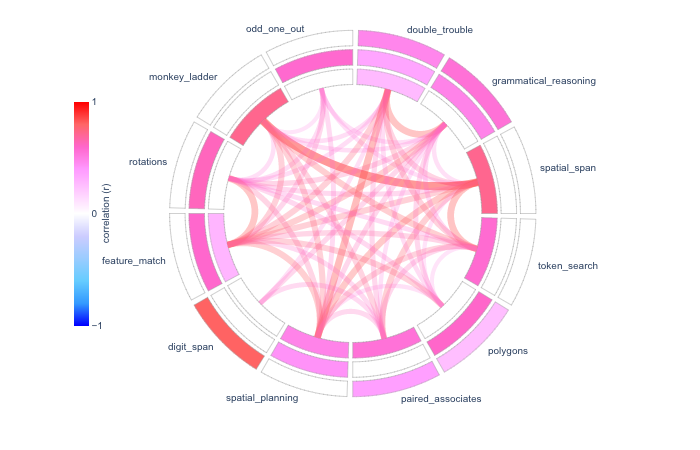

In [3]:
Ypca = FactorAnalyzer(
	method='principal',
	n_factors=3, 
	rotation='varimax').fit(Zctrl[df_])

# I know the scores turn out in this order....
pca_names = ['STM', 'reasoning', 'verbal']
loadings = pd.DataFrame(
	Ypca.loadings_, index=cbs.test_names(), columns=pca_names)
var_corrs = pd.DataFrame(
	Ypca.corr_, index=cbs.test_names(), columns=cbs.test_names())
eigen_values = pd.DataFrame(
	Ypca.get_eigenvalues()[0][0:3], index=pca_names, columns=['eigenvalues']).T
pct_variance = pd.DataFrame(
	Ypca.get_factor_variance()[1]*100, index=pca_names, columns=['% variance']).T

# Generates and displays the chord plot to visualize the factors
fig = chord_plot(
	loadings.copy(), var_corrs.copy(), 
	cscale_name='Picnic', width=700, height=350, threshold=0.20)
fig.write_image('./images/score_PCA.svg')

fig.show(renderer="png")


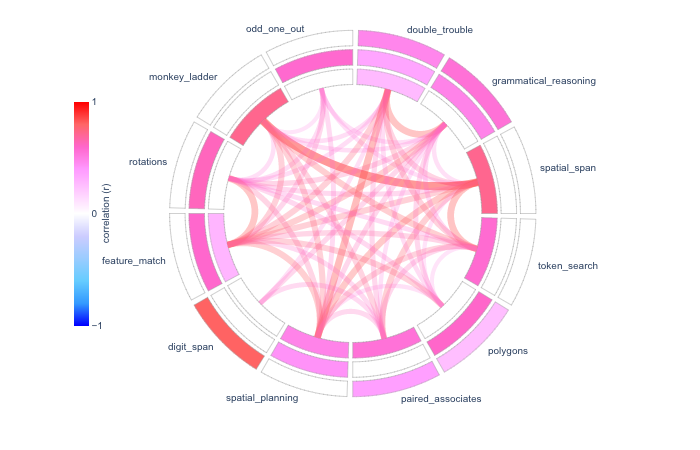

In [4]:
# Perform a PCA of the 12 primary CBS measures specifying 3 components and a
# varimax rotation. These choices are based on previous work with these tests:
# Hampshire et al (2012), Wild et al (2018).
Ypca = FactorAnalyzer(
	method='principal',
	n_factors=3, 
	rotation='varimax').fit(Zctrl[df_])

# I know the scores turn out in this order....
pca_names = ['STM', 'reasoning', 'verbal']

# Build dataframes of correlations, loadings, eigenvalues etc. for use in the
# figure and table.
loadings = pd.DataFrame(
	Ypca.loadings_, index=cbs.test_names(), columns=pca_names)
var_corrs = pd.DataFrame(
	Ypca.corr_, index=cbs.test_names(), columns=cbs.test_names())
eigen_values = pd.DataFrame(
	Ypca.get_eigenvalues()[0][0:3], index=pca_names, columns=['eigenvalues']).T
pct_variance = pd.DataFrame(
	Ypca.get_factor_variance()[1]*100, index=pca_names, columns=['% variance']).T

# Generates and displays the chord plot to visualize the factors
fig = chord_plot(
	loadings.copy(), var_corrs.copy(), 
	cscale_name='Picnic', width=700, height=350, threshold=0.20)
fig.write_image('./images/score_PCA.svg')

fig.show(renderer="png")


In [5]:
# Generate a table of task to composite score loadings
loadings = (pd
	.concat([loadings, eigen_values, pct_variance], axis=0)
	.join(Yctrl_stats[df_]
		.T.rename(index={r[0]: r[1] for r in zip(df_, cbs.test_names())}))
	.loc[:, ['mean', 'std']+pca_names]
)

loadings.to_csv('./tables/pca_loadings.csv')
loadings


,mean,std,STM,reasoning,verbal
spatial_span,5.6563,1.0641,0.7197,0.1960,0.0787
grammatical_reasoning,17.8733,5.1820,0.0620,0.4856,0.5552
double_trouble,25.0790,15.2464,0.2713,0.3527,0.4733
odd_one_out,15.8421,2.1321,0.1907,0.5878,-0.1025
monkey_ladder,7.6969,1.1572,0.7215,0.1626,0.0367
rotations,76.1176,34.9451,0.1981,0.6294,0.0472
feature_match,114.0567,29.5088,0.2918,0.5970,0.1541
digit_span,6.6579,1.3975,0.1644,-0.0637,0.8054
spatial_planning,19.0095,9.7317,0.4845,0.4270,0.0632
paired_associates,4.6611,0.9847,0.5538,0.0230,0.3774


 ### Calculate Composite Cognitive Scores (Control Group)

In [6]:
# Calculates the 3 cognitive domain scores from the fitted PCA model
Zctrl[pca_names] = Ypca.transform(Zctrl[df_])

# Measure of processing speed:
# take the 1st Prinicipal Component across timing-related features (tf_)
Yspd = FactorAnalyzer(
	method='principal', 
	n_factors=1,
	rotation=None).fit(Zctrl[tf_])
Zctrl['processing_speed'] = Yspd.transform(Zctrl[tf_])

# Overall measure across CBS battery:
# the average of all 12 task z-scores (rescaled to have SD=1.0) 
Zctrl['overall'] = Zctrl[df_].mean(axis=1)
Yavg_tfm = StandardScaler(with_mean=True, with_std=True).fit(Zctrl[['overall']])
Zctrl['overall'] = Yavg_tfm.transform(Zctrl[['overall']])


 ## Relationship between socio-demographic variables and cognitive performance.
 - Estimate these from the control dataset using linear regression

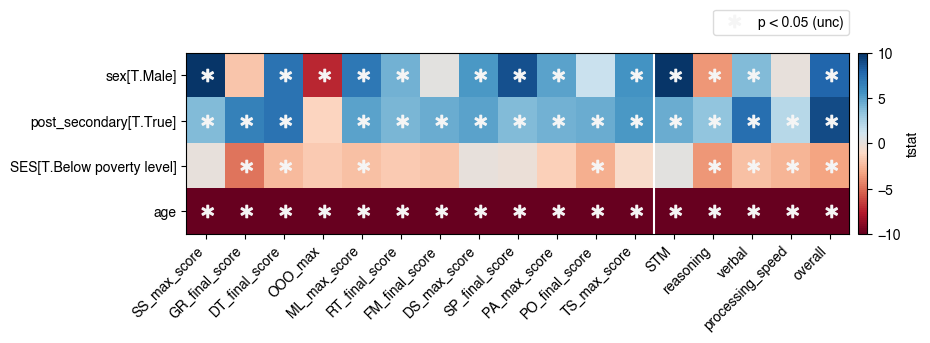

In [8]:
# Copy the dataset, because we modify the age variable (mean centre it)
Zctrl_ = Zctrl.copy()
Zctrl_.age -= Zctrl_.age.mean()

comp_scores = cbs.DOMAIN_NAMES+['processing_speed', 'overall']
test_scores = df_

Yvar = test_scores+comp_scores
expr = ws.build_model_expression(Xcovar)

# Generate a summary figure to show significant (p < 0.05) effects.
r, _ = ws.regression_analyses(expr, Yvar, Zctrl_)
f = wp.create_stats_figure(
		r.drop('Intercept', level='contrast', axis=0),
		'tstat', 'p', stat_range=[-10, 10], diverging=5, vertline=5)


In [9]:
from sklearn.preprocessing import PolynomialFeatures

# Estimate and save the betas so we can correct the COVID+ data for the same
# variables. Note that we model age using linear+quadratic terms.
age_tfm = Pipeline(steps=[
	('center', StandardScaler(with_mean=True, with_std=False)),
	('poly', PolynomialFeatures(degree=2, include_bias=False)),
])

Xtfm = ColumnTransformer([
	('cont',  age_tfm, ['age']),
	('c_sex', OneHotEncoder(drop=['Female']), ['sex']),
	('c_edu', OneHotEncoder(drop=[True]), ['post_secondary']),
	('c_ses', OneHotEncoder(drop=['At or above poverty level']), ['SES']),
]).fit(Zctrl[Xcovar])

# Another X transformer, but we just mean centre age instead of polynomial
# expansions.
Xtfm_ = ColumnTransformer([
	('cont',  StandardScaler(with_mean=True, with_std=False), ['age']),
	('c_sex', OneHotEncoder(drop=['Female']), ['sex']),
	('c_edu', OneHotEncoder(drop=[False]), ['post_secondary']),
	('c_ses', OneHotEncoder(drop=['At or above poverty level']), ['SES']),
]).fit(Zctrl[Xcovar])

Xss = Xtfm.transform(Zctrl[Xcovar])
Xss = np.c_[Xss, np.ones(Xss.shape[0])]
Bss = np.dot(pinv(Xss), Zctrl[Yvar])


 ## COVID+ (2020-21) Dataset

In [10]:
# Variables to keep track of
mhvars   = ['GAD2', 'PHQ2']
subjvars = ['subjective_memory', 'baseline_functioning']
sf36vars = list(CC.questionnaire.SF36_map.keys())
severity = ['WHOc']

print("\nCC Questionnaire:")
Qcc = (CC.questionnaire.data
	.rename(columns={'ses': 'SES'})
	.pipe(report_N, 'initial questionnaires', reset_count=True)
	.query('~index.duplicated(keep="first")')
	.pipe(report_N, 'remove duplicates')
	.assign(post_secondary = lambda x: x.education > 'Some university or college, no diploma')
)

Qcc.subjective_memory = Qcc.subjective_memory.cat.codes

Qcc.WHOc = (Qcc.WHOc
	.map({'0': '0-1', '1': '0-1', '2': '2', '3+': '3+'})
	.astype("category")
)

print("\nCC Scores:")
Ycc = (CC.score_data()
	.pipe(set_column_names, af_)
	.reset_index('device_type')
	.groupby('user')
	.first()
	.pipe(report_N, 'initial scores', reset_count=True)
	.query('~(device_type in ["BOT", "CONSOLE", "MOBILE"])')
	.pipe(report_N, 'drop unsupported devices')
)

print("\nCC Dataset:")
Zcc = (Ycc
	.join(Qcc, how='left')
	.pipe(report_N, 'join data', reset_count=True)
	.query('(age >= 18)')
	.pipe(report_N, '>= 18 years')
	.query('(age <= 100)')
	.pipe(report_N, '<= 100 years')
	.query('sex in ["Male", "Female"]')
	.pipe(report_N, 'filter age')
	.pipe(ws.filter_df, subset=df_, sds=[6], drop=True)
	.pipe(report_N, '6 SD filter')
	.pipe(ws.filter_df, subset=df_, sds=[4], drop=True)
	.pipe(report_N, '4 SD filter')
	.dropna(subset=af_+Xcovar+mhvars+subjvars+sf36vars+severity)
	.pipe(report_N, 'drop cases with any missing values')
	.query('positive_test == "Yes"')
	.pipe(report_N, 'drop NO to positive test')
	.drop(columns=['positive_test'])
	.dropna(subset=['days_since_test'])
	.pipe(report_N, 'without a test date')
	.pipe(report_N, 'final')
	.pipe(remove_unused_categories)
)

# Standardizes all score features using the control means and stdevs
Zcc[af_] = Ytfm.transform(Zcc[af_])

# Calculate the composite scores
Zcc[pca_names] = Ypca.transform(Zcc[df_])
Zcc['processing_speed'] = Yspd.transform(Zcc[tf_])
Zcc['overall'] = Yavg_tfm.transform(Zcc[df_].mean(axis=1).values.reshape(-1,1))

# Adjust for effects of covariates
Xcc = Xtfm.transform(Zcc[Xcovar])
Xcc = np.c_[Xcc, np.ones(Xcc.shape[0])]
Ycc_hat = Xcc.dot(Bss)
Zcc[Yvar] -= Ycc_hat

Zcc = Zcc.rename(columns={'WHOi': 'WHO_COVID_severity'})



CC Questionnaire:
N =  1745,  +1745 (initial questionnaires)
N =  1745,     +0 (remove duplicates)

CC Scores:
N =  1379,  +1379 (initial scores)
N =  1378,     -1 (drop unsupported devices)

CC Dataset:
N =  1378,  +1378 (join data)
N =  1188,   -190 (>= 18 years)
N =  1188,     +0 (<= 100 years)
N =  1184,     -4 (filter age)
N =  1181,     -3 (6 SD filter)
N =  1161,    -20 (4 SD filter)
N =   954,   -207 (drop cases with any missing values)
N =   491,   -463 (drop NO to positive test)
N =   485,     -6 (without a test date)
N =   485,     +0 (final)


In [11]:
covid_vars = ['symptoms', 'hospital_stay', 'daily_routine', 'supplemental_O2_hospital', 'ICU_stay', 'ventilator']
q_counts = Zcc[covid_vars]
q_counts['symptoms'] = q_counts['symptoms'].map({True: "Yes", False: "No"})
q_counts = [q_counts[c].value_counts() for c in covid_vars]
q_counts = pd.concat(q_counts, axis=1).T

covar_data = pd.concat(
	[Zctrl[Xcovar], Zcc[Xcovar]], axis=0, 
	names=['dataset'], keys=['Control', 'COVID+'])

for v in ['sex', 'post_secondary', 'SES']:
	print("\n")
	print(covar_data.groupby('dataset')[v].value_counts())

print("\n")
print(covar_data.groupby(['dataset']).agg(['mean', 'std']).T)
# age_table.to_csv('../tables/continuous_covars.csv')




dataset  sex   
Control  Female    5539
         Male      3276
COVID+   Female     341
         Male       144
Name: sex, dtype: int64


dataset  post_secondary
Control  True              6665
         False             2150
COVID+   True               400
         False               85
Name: post_secondary, dtype: int64


dataset  SES                      
Control  At or above poverty level    8226
         Below poverty level           589
COVID+   At or above poverty level     449
         Below poverty level            36
Name: SES, dtype: int64


dataset   Control  COVID+
age mean  42.7575 43.3320
    std   14.4434 13.1664
/Users/conorwild/CBS/noncbs-data-projects/2021-Wild-et-al-COVID-Cognition/covid_cognition.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

 ### GAD-2 & PHQ-2 Summary

In [12]:
n_GAD_flag = (Zcc.GAD2>=3).sum()
print(f"GAD2 >= 3, N = {n_GAD_flag} ({n_GAD_flag/Zcc.shape[0]*100:.01f}%)")

n_PHQ_flag = (Zcc.PHQ2>=3).sum()
print(f"PHQ2 >= 3, N = {n_PHQ_flag} ({n_PHQ_flag/Zcc.shape[0]*100:.01f}%)")


GAD2 >= 3, N = 160 (33.0%)
PHQ2 >= 3, N = 153 (31.5%)


In [13]:
do_demo_plots = False
if do_demo_plots:

	f = wp.histogram(
			Zcc, 'age', range(0, 100, 10),
			layout_args = { 
				'xaxis': {'tickmode': 'linear', 'tick0': 0, 'dtick': 10 }})
	iplot(f)

	f = wp.pie_plot(
			Zcc, 'sex', 
			marker = {'colors': ['rgb(204, 97, 176)', 'rgb(93, 105, 177)']})
	iplot(f)

	f = wp.pie_plot(Zcc, 'post_secondary', marker = {'colors': wp.dark2[0:2]})
	iplot(f)

	x = Zcc[(Zcc.days_since_test > 0)&(Zcc.days_since_test < 300)]
	f = wp.histogram(
			x, 'days_since_test', range(0, 270, 30),
			bar_args = {
				'color_discrete_sequence': plotly.colors.qualitative.Pastel},
			layout_args = { 
				'xaxis': { 'tickmode': 'linear', 'tick0': 0, 'dtick': 30 }})
	iplot(f)

	c = Zcc.groupby('WHO').agg(['count']).xs('duration', level=0, axis=1)
	c['WHO Score'] = np.arange(0, 7)
	f = px.bar(c, x='WHO Score', y='count', color='WHO Score', text='count')
	f.update_layout(width=350, height=400,
			margin = {'t': 20, 'r': 10, 'l': 70, 'b': 20},
			coloraxis_showscale=False)
	f.update_traces(textfont_size=10)
	f.update_xaxes(tickvals=c['WHO Score'])
	f.update_yaxes(title="# of Subjects")
	iplot(f)


 ## Process Health Measures Data

In [14]:
# The variables we are looking at
fvars = mhvars + subjvars + sf36vars + ['WHO_COVID_severity', 'days_since_test']
fdata = Zcc[fvars].copy().dropna()

var_rename = {
	'baseline_functioning_Yes': 'subj_baseline',
	'baseline_functioning': 'subj_baseline',
	'subjective_memory': 'subj_memory',
	'days_since_test': 'days_since_+test'
}

var_order = sf36vars + mhvars + [
	'subj_memory',
	'subj_baseline',
	'WHO_COVID_severity',
	'days_since_+test']

fdata.WHO_COVID_severity = fdata.WHO_COVID_severity >= 2
fdata_tfm = ColumnTransformer([
	('z', StandardScaler(), sf36vars+['days_since_test']),
	('r', MinMaxScaler(feature_range=(-1,1)), mhvars+['subjective_memory', 'WHO_COVID_severity']),
	('c', OneHotEncoder(drop='first'), ['baseline_functioning']),
]).fit(fdata)

fdata_desc = (fdata
	.assign(baseline_functioning=fdata['baseline_functioning'].cat.codes)
	.agg(['mean', 'std']).T
	.rename(var_rename)
	.loc[var_order, :]
)

fdata0 = (pd
	.DataFrame(
		fdata_tfm.transform(fdata),
		index=fdata.index,
		columns=wsk.get_ct_feature_names(fdata_tfm))
	.rename(columns=var_rename)
	.loc[:, var_order]
)

# Reverse GAD-2 and PHQ-2 so they go in the same direction as other measures
# for these plots, and calculations of factor scores.
fdata0[mhvars] *= -1

fa1 = FactorAnalyzer(rotation=None).fit(fdata0)
nf = (fa1.get_eigenvalues()[1]>1).sum()
fnames = [f"F{i+1}" for i in range(nf)]

# Bartlett; p-value should be 0 (statistically sig.)
chi_square_value,p_value=calculate_bartlett_sphericity(fdata0)
print(chi_square_value, p_value)

# KMO; Value should be > 0.6
kmo_all,kmo_model=calculate_kmo(fdata0)
print(kmo_model)

rotation = "varimax"
fa = FactorAnalyzer(nf, rotation=rotation)
fa = fa.fit(fdata0)

Zcc[fnames] = np.nan
Zcc.loc[fdata0.index, fnames] = (
	StandardScaler()
	.fit_transform(
		fa.transform(fdata0)
	)
)

loadings = pd.DataFrame(
	fa.loadings_, index=fdata0.columns, columns=fnames)
eigen_values = pd.DataFrame(
	fa.get_eigenvalues()[0][0:nf], index=fnames, columns=['eigenvalues']).T
pct_variance = pd.DataFrame(
	fa.get_factor_variance()[1]*100, index=fnames, columns=['% variance']).T

table = (pd
	.concat([loadings, eigen_values, pct_variance], axis=0)
	.join(fdata_desc)
	.loc[:, ['mean', 'std']+fnames]
)

write_tables, write_images = True, True

if False:
	fdata0.corr().to_csv('../tables/hm_correlations.csv')
	table.to_csv(f"../tables/Table_S2.csv")


f = chord_plot(
		loadings, fdata0[var_order].corr(), 
		width=800, height=350, cscale_name='Picnic', threshold=0.20)
iplot(f)

if False:
	f.write_image(f"../images/HM_factor_{rotation}.svg")


Zall = pd.concat([Zcc, Zctrl], axis=0, keys=['CC', 'CTRL'], names=['study'])


2209.1746901404317 0.0
0.8733823624492298


NameError: name 'iplot' is not defined

2209.1746901404317 0.0
0.8733823624492298


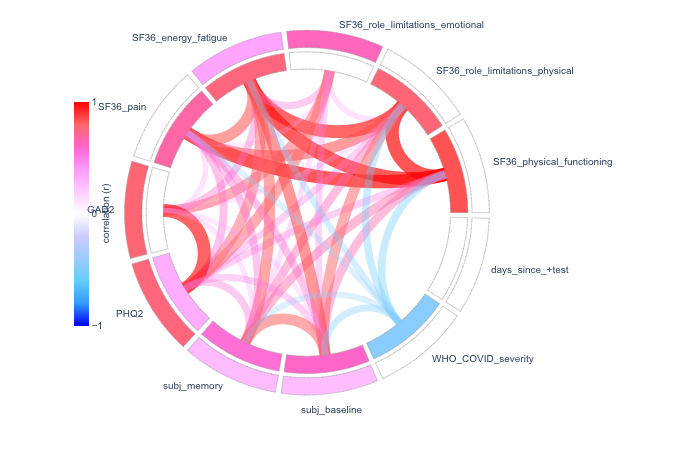

In [15]:
# The variables we are looking at
fvars = mhvars + subjvars + sf36vars + ['WHO_COVID_severity', 'days_since_test']
fdata = Zcc[fvars].copy().dropna()

var_rename = {
	'baseline_functioning_Yes': 'subj_baseline',
	'baseline_functioning': 'subj_baseline',
	'subjective_memory': 'subj_memory',
	'days_since_test': 'days_since_+test'
}

var_order = sf36vars + mhvars + [
	'subj_memory',
	'subj_baseline',
	'WHO_COVID_severity',
	'days_since_+test']

fdata.WHO_COVID_severity = fdata.WHO_COVID_severity >= 2
fdata_tfm = ColumnTransformer([
	('z', StandardScaler(), sf36vars+['days_since_test']),
	('r', MinMaxScaler(feature_range=(-1,1)), mhvars+['subjective_memory', 'WHO_COVID_severity']),
	('c', OneHotEncoder(drop='first'), ['baseline_functioning']),
]).fit(fdata)

fdata_desc = (fdata
	.assign(baseline_functioning=fdata['baseline_functioning'].cat.codes)
	.agg(['mean', 'std']).T
	.rename(var_rename)
	.loc[var_order, :]
)

fdata0 = (pd
	.DataFrame(
		fdata_tfm.transform(fdata),
		index=fdata.index,
		columns=wsk.get_ct_feature_names(fdata_tfm))
	.rename(columns=var_rename)
	.loc[:, var_order]
)

# Reverse GAD-2 and PHQ-2 so they go in the same direction as other measures
# for these plots, and calculations of factor scores.
fdata0[mhvars] *= -1

fa1 = FactorAnalyzer(rotation=None).fit(fdata0)
nf = (fa1.get_eigenvalues()[1]>1).sum()
fnames = [f"F{i+1}" for i in range(nf)]

# Bartlett; p-value should be 0 (statistically sig.)
chi_square_value,p_value=calculate_bartlett_sphericity(fdata0)
print(chi_square_value, p_value)

# KMO; Value should be > 0.6
kmo_all,kmo_model=calculate_kmo(fdata0)
print(kmo_model)

rotation = "varimax"
fa = FactorAnalyzer(nf, rotation=rotation)
fa = fa.fit(fdata0)

Zcc[fnames] = np.nan
Zcc.loc[fdata0.index, fnames] = (
	StandardScaler()
	.fit_transform(
		fa.transform(fdata0)
	)
)

loadings = pd.DataFrame(
	fa.loadings_, index=fdata0.columns, columns=fnames)
eigen_values = pd.DataFrame(
	fa.get_eigenvalues()[0][0:nf], index=fnames, columns=['eigenvalues']).T
pct_variance = pd.DataFrame(
	fa.get_factor_variance()[1]*100, index=fnames, columns=['% variance']).T

table = (pd
	.concat([loadings, eigen_values, pct_variance], axis=0)
	.join(fdata_desc)
	.loc[:, ['mean', 'std']+fnames]
)

write_tables, write_images = True, True

if False:
	fdata0.corr().to_csv('../tables/hm_correlations.csv')
	table.to_csv(f"../tables/Table_S2.csv")


f = chord_plot(
		loadings, fdata0[var_order].corr(), 
		width=800, height=350, cscale_name='Picnic', threshold=0.20)
f.show(renderer='png')

if False:
	f.write_image(f"../images/HM_factor_{rotation}.svg")


In [18]:
# Correlations between health measures (same as shown in the above chord plot)
f = wp.correlogram(fdata0, subset=var_order, mask_diag=True, thresh=0.2)
if False:
	f.write_image(f"../images/HM_correlogram.svg")
f


In [19]:
# Concatenate the COVID+ and Control datasets for subsetquent comparions 
# betweeb groups
Zall = pd.concat([Zcc, Zctrl], axis=0, keys=['CC', 'CTRL'], names=['study'])



In [20]:
# Helper variables for processing the statistics tables
comp_columns = ['dR2', 'f2', 'BF10']
regr_columns = ['B', 'tstat', 'df', 'p_adj', 'CI']
ttest_columns = ['diff', 'tstat', 'df', 'p_adj', 'CI', 'BF10']
column_order = regr_columns + comp_columns

def pval_format(p):
	if p < 0.001:
		return "< 0.001"
	else:
		return f"{p:.03f}"

def bf_format(bf):
	if isinstance(bf, str):
		bf = float(bf)
	if bf > 1000:
		return "> 1000"
	else:
		return f"{bf:.02f}"

def ci_format(ci, precision=3):
	return f"({ci[0]:.{precision}f}, {ci[1]:.{precision}f})"

def styled_df(df):
	return df.style.format(table_style)

def write_df_to_html(df, fn):
	with open(f"./tables/{fn}.html", 'w') as wf:
		wf.write(styled_df(df).render())

table_style = {
	'B': '{:.2f}',
	'tstat': '{:.2f}',
	'df': '{:.2f}',
	'p_adj': pval_format,
	'CI': ci_format,
	'dR2': '{:.3f}',
	'f2': '{:.3f}',
	'd': '{:.2f}',
	'BF10': bf_format,
}



 ## Relationships Between Factor Scores and Covariates

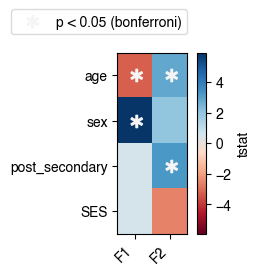

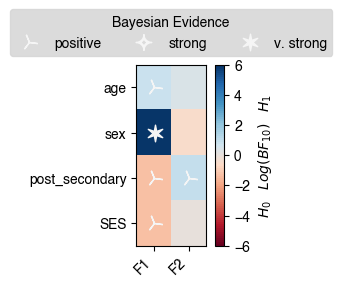

In [21]:
Zcc_ = Zcc.copy()
Zcc[Xcovar] = Xtfm_.transform(Zcc[Xcovar])

r0_regressions, _ = ws.regression_analyses(
	'%s ~ age + sex + post_secondary + SES', fnames, Zcc, n_comparisons=8)

r0_comparisons = ws.compare_models([
	{ 'name': 'age',
		'h0': '%s ~ sex + post_secondary + SES', 
		'h1': '%s ~ age + sex + post_secondary + SES' }, 
	{ 'name': 'sex',
		'h0': '%s ~ age + post_secondary + SES', 
		'h1': '%s ~ age + sex + post_secondary + SES' },
	{ 'name': 'post_secondary',
		'h0': '%s ~ age + sex + SES', 
		'h1': '%s ~ age + sex + post_secondary + SES' },
	{ 'name': 'SES',
		'h0': '%s ~ age + sex + post_secondary', 
		'h1': '%s ~ age + sex + post_secondary + SES' }],

	Zcc, fnames, smf.ols, n_comparisons=8)

# Combine and reorganize the results tables
res0 = (r0_regressions
	.drop('Intercept', level='contrast')
	.join(r0_comparisons.loc[:, comp_columns])
	.rename(columns={'value': 'B'})
	.loc[:, column_order]
)

f1_ts = wp.create_stats_figure(
	res0, 'tstat', 'p_adj', diverging=True, vertline=None, 
	correction='bonferroni')

f1_bf = wp.create_bayes_factors_figure(res0, cell_scale=0.6)

if False:
	# f1_ts.savefig('../images/f0_tstats.svg')
	# f1_bf.savefig('../images/f0_bayes.svg')
	write_df_to_html(res0, 'Table_S4')

styled_df(res0)

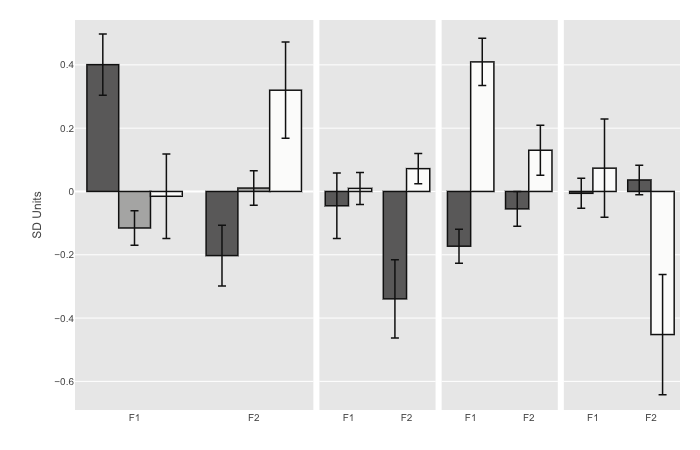

In [23]:
# Plots of Mean Factors Scores vs. Covariates

import plotly.graph_objects as go
bwmap = wc.create_mpl_cmap(plotly.colors.sequential.gray, alpha=1.0)

# age_edges = np.append(Zcc_.age.quantile(np.arange(0, 1, 1/5)).values, 100)
age_edges = np.array([18, 30, 60, 100])
age_bins = ['18-30', '30-60', '60+']
# age_bins = [f"{age_edges[i]:.0f}-{age_edges[i+1]:.0f}" for i in range(len(age_edges)-1)]
Zcc_['age_bin'] = pd.cut(Zcc_['age'], age_edges, labels=age_bins)

from plotly.subplots import make_subplots
plot_vars = ['age_bin', 'post_secondary', 'sex', 'SES']
fig = make_subplots(
    rows=1, cols=len(Xcovar)+1, shared_yaxes=True, horizontal_spacing = 0.01,
	specs=[[{'colspan': 2}, {'colspan': 1}, {'colspan': 1}, {'colspan': 1}, {'colspan': 1}]]
)

for ifig, x in enumerate(plot_vars):
	means = Zcc_.groupby(x).agg(['mean', 'count', 'std'])[fnames].stack(0)
	means['mean_se'] = means['std']/np.sqrt(means['count'])
	means = means.unstack(1).swaplevel(axis=1)
	grps = list(means.index.unique())
	ir, ic = 1, ifig+1
	if ifig > 0:
		ic += 1
	for itrace, g in enumerate(grps):
		cmap = wc.to_RGB_255(bwmap(np.linspace(0.4, 1.0, len(grps))))
		fig.add_trace(
			go.Bar(
				name=g, x=fnames, y=means.loc[g, idx[:, 'mean']],
				marker_color=cmap[itrace],
				error_y={
					'type': 'data', 
					'array': means.loc[g, idx[:, 'mean_se']]
				}),
		row=ir, col=ic)
		# fig.update_xaxes(title_text='Factor', row=1, col=ifig+2)

fig.update_yaxes(title_text='SD Units', row=1, col=1)
fig.update_layout(
	yaxis={'zerolinewidth': 2},
	template=wp.plotly_template(),
	showlegend=False,
	margin={'l': 75, 'b': 40, 't': 20, 'r': 20},
	width=650, height=275)

fig.show(renderer='png')

if False:
	fig.write_image('../images/Figure_2.svg')


 ## Regress Cognitive Scores on to Health Factor Scores

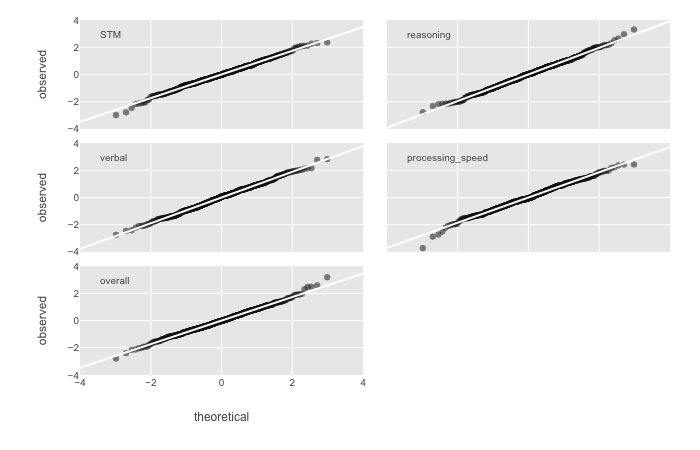

In [25]:
# QQ Plot of Residuals
adj = 'bonferroni'
r1_regressions, r1_models = ws.regression_analyses(
	'%s ~ F1 + F2', comp_scores, Zcc, n_comparisons=15)

## QQ-Plots of residuals from linear regression models
qq_nms, qq_res = np.empty([3, 2], dtype='object'), np.empty([3,2], dtype='object')
for im, m in enumerate(r1_models):
	ir, ic = np.unravel_index(im, [3,2])
	qq_res[ir, ic] = probplot(m.resid, dist="norm")
	qq_nms[ir, ic] = m.model.endog_names

qq_f = wp.qq_plots(qq_res, qq_nms,
	layout_args = {'width': 400, 'height': 400}
)

if write_images:
	qq_f.write_image('./images/r1_qq.svg')

qq_f.show(renderer='png')


In [27]:
# Perform regressions,  model comparisons, and t-tests
OUTDATED_IGNORE=1
r1_comparisons = ws.compare_models([
	{'name': 'F1',
		'h0': '%s ~ 1 + F2', 
		'h1': '%s ~ 1 + F1 + F2'}, 
	{'name': 'F2',
		'h0': '%s ~ 1 + F1', 
		'h1': '%s ~ 1 + F1 + F2'}],
	Zcc, comp_scores, smf.ols, n_comparisons=15)

r1_ttests = (ws
	.two_sample_ttests('study', comp_scores, Zall, n_comparisons=15)
	.droplevel('contrast')
)


res1_ = (r1_regressions
	.join(r1_comparisons.loc[:, comp_columns])
	.loc[r1_regressions.index, :]
	.drop('Intercept', level='contrast')
	.rename(columns={'value': 'B'})
)

if False:
	write_df_to_html(r1_ttests[ttest_columns], 'Table_3')
	write_df_to_html(res1_[column_order], 'Table_4')

styled_df(r1_ttests[ttest_columns])


,diff,tstat,df,p_adj,CI,BF10
score,,,,,,
STM,0.048851,1.20,557.04,1.000,"(-0.072, 0.169)",0.11
reasoning,-0.183835,-4.01,540.84,0.001,"(-0.319, -0.049)",153.69
verbal,-0.171325,-3.84,544.28,0.002,"(-0.303, -0.040)",79.14
processing_speed,-0.294725,-6.71,546.17,< 0.001,"(-0.424, -0.165)",> 1000
overall,-0.154197,-3.75,556.00,0.003,"(-0.275, -0.033)",55.84


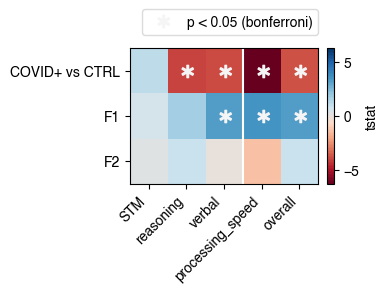

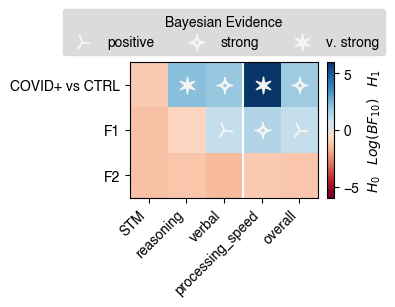

In [28]:

plot_cols = ['tstat', 'p_adj', 'BF10']
renamer = {'group': 'COVID+ vs CTRL'}
res1_fig = (
	pd.concat(
		[pd.concat([r1_ttests[plot_cols]], keys=['group'], names=['contrast']).swaplevel(),
		 res1_[plot_cols]], axis=0
	)
	.loc[idx[comp_scores, :], :]
	.rename(renamer)
)

f1_ts = wp.create_stats_figure(
	res1_fig, 'tstat', 'p_adj', diverging=True, vertline=2,
	correction=adj, stat_range=[-6.3, 6.3])

f1_bf = wp.create_bayes_factors_figure(res1_fig, suppress_h0=True, vertline=2)

if False:
	f1_ts.savefig('../images/Figure_5a.svg')
	f1_bf.savefig('../images/Figure_5b.svg')



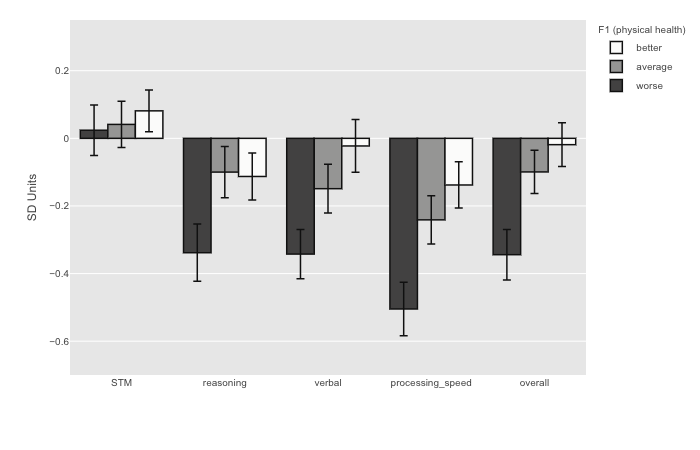

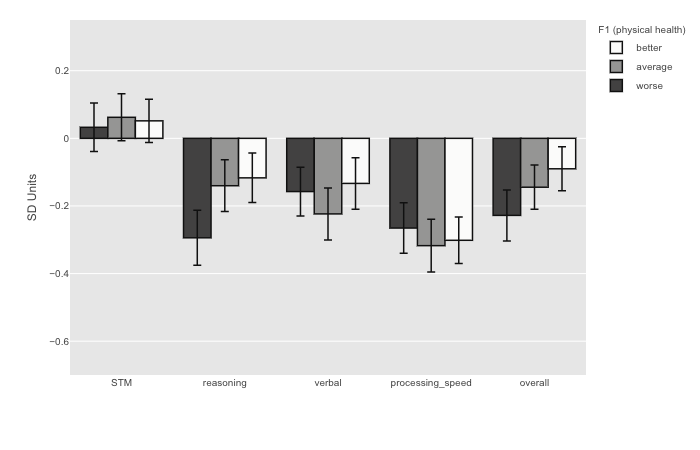

In [29]:
f1_edges = np.array([-np.Inf, *Zcc['F1'].quantile(q=np.array([1,2])/3).values, np.Inf])
f2_edges = np.array([-np.Inf, *Zcc['F2'].quantile(q=np.array([1,2])/3).values, np.Inf])
labels = ["worse", "average", "better"]
Zcc['F1_bin'] = pd.cut(Zcc['F1'], bins=f1_edges, labels=labels)
Zcc['F2_bin'] = pd.cut(Zcc['F2'], bins=f2_edges, labels=labels)

bar_args = {
	'range_y': [-0.7, 0.35],
	'labels': {'mean': 'SD Units'},
}

layout_args = {
	'xaxis': {
		'title': None, 
	},
	'yaxis': {
		'tickmode': 'array',
		'tickvals': np.arange(-0.6, 0.7, 0.2).round(1),
	},
	'width': 400, 'height': 275,
	'margin': {'l': 70, 'b': 75, 't': 20, 'r': 20},
	'legend_traceorder': 'reversed',
	'legend': {
		'title': "F1 (physical health)", 'orientation': 'v',
		'yanchor': 'top', 'xanchor': 'left', 'x': 1.02, 'y': 1.0,
	},
}
grayscale_map = wc.to_RGB_255(bwmap(np.linspace(0.3, 1.0, 3)))

f3a, _ = wp.means_plot(
	Zcc, comp_scores, 'score', group='F1_bin',
	group_color_sequence=grayscale_map,
	bar_args=bar_args, layout_args=layout_args 
)
f3a.show(renderer='png')

f3b, _ = wp.means_plot(
	Zcc, comp_scores, 'score', group='F2_bin',
	group_color_sequence=grayscale_map,
	bar_args=bar_args, layout_args=layout_args 
)
f3b.show(renderer='png')

if False:
	f3a.write_image('../images/Figure_3a.svg')
	f3b.write_image('../images/Figure_3b.svg')



In [30]:
# Compare groups in F1 bins to controls
r3a_ttests = {}
for grp, grp_data in Zcc.groupby('F1_bin'):
	Zall = pd.concat([grp_data, Zctrl], keys=['CC', 'SS'], names=['study'])
	r3a_ttests[grp] = (ws
		.two_sample_ttests('study', comp_scores, Zall, n_comparisons=15)
		.droplevel('contrast')
	)
r3a_ttests = pd.concat(r3a_ttests.values(), axis=0, keys=r3a_ttests.keys(), names=['F1_bin'])

if True:
	write_df_to_html(r3a_ttests[ttest_columns], 'Table_S5')

styled_df(r3a_ttests[ttest_columns])


In [31]:
# Compare groups in F2 bins to controls
r3b_ttests = {}
for grp, grp_data in Zcc.groupby('F2_bin'):
	Zall = pd.concat([grp_data, Zctrl], keys=['CC', 'SS'], names=['study'])
	r3b_ttests[grp] = (ws
		.two_sample_ttests('study', comp_scores, Zall, n_comparisons=15)
		.droplevel('contrast')
	)
r3b_ttests = pd.concat(r3b_ttests.values(), axis=0, keys=r3b_ttests.keys(), names=['F2_bin'])

if True:
	write_df_to_html(r3b_ttests[ttest_columns], 'Table_S5b')
styled_df(r3b_ttests[ttest_columns])


 ## Supplementary Analysis - Include Covariates
 - They've already been regressed out, but let's try anyways.

In [32]:
# Include covariates in the model expression(s)
r1b_regressions, _ = ws.regression_analyses(
	'%s ~ F1 + F2 + age + sex + post_secondary + SES', comp_scores, Zcc, n_comparisons=15)

r1b_comparisons = ws.compare_models([
	{'name': 'F1',
		'h0': '%s ~ 1 + F2 + age + sex + post_secondary + SES', 
		'h1': '%s ~ 1 + F1 + F2 + age + sex + post_secondary + SES'}, 
	{'name': 'F2',
		'h0': '%s ~ 1 + F1 + age + sex + post_secondary + SES', 
		'h1': '%s ~ 1 + F1 + F2 + age + sex + post_secondary + SES'}],
	Zcc, comp_scores, smf.ols, n_comparisons=15)


res1b_ = (r1b_regressions
	.join(r1b_comparisons.loc[:, comp_columns])
	.loc[r1b_comparisons.index, :]
	.rename(columns={'value': 'B'})
)

if False:
	write_df_to_html(res1b_[column_order], 'Table_S6')

styled_df(res1b_[column_order])


 ## Subgroup Analyses - Hospitalised vs Non-Hospitalised Cases

In [34]:
# Compare Hospitalised Groups (T-Tests)
r5a_ttests = (ws
	.two_sample_ttests('hospital_stay', comp_scores+fnames, Zcc, n_comparisons=7)
	.droplevel('contrast')
	.rename(columns={'cohen-d': 'd'})
)

if True:
	write_df_to_html(r5a_ttests[ttest_columns], 'Table_S7')

styled_df(r5a_ttests[ttest_columns])


,diff,tstat,df,p_adj,CI,BF10
score,,,,,,
STM,-0.185016,-1.58,86.98,0.819,"(-0.507, 0.137)",0.47
reasoning,0.332457,2.52,86.86,0.094,"(-0.030, 0.695)",2.88
verbal,0.108738,0.95,95.71,1.000,"(-0.205, 0.423)",0.22
processing_speed,0.301019,2.24,83.33,0.195,"(-0.070, 0.672)",1.52
overall,0.135492,1.08,83.39,1.000,"(-0.211, 0.482)",0.25
F1,0.492390,3.89,90.27,0.001,"(0.144, 0.841)",170.87
F2,-0.003311,-0.02,85.49,1.000,"(-0.385, 0.379)",0.14


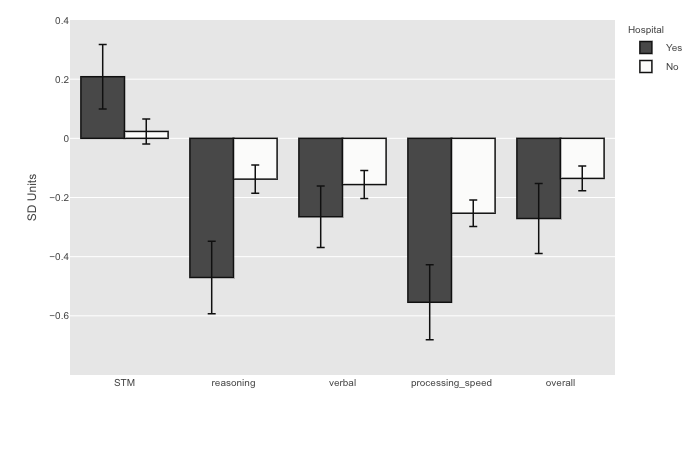

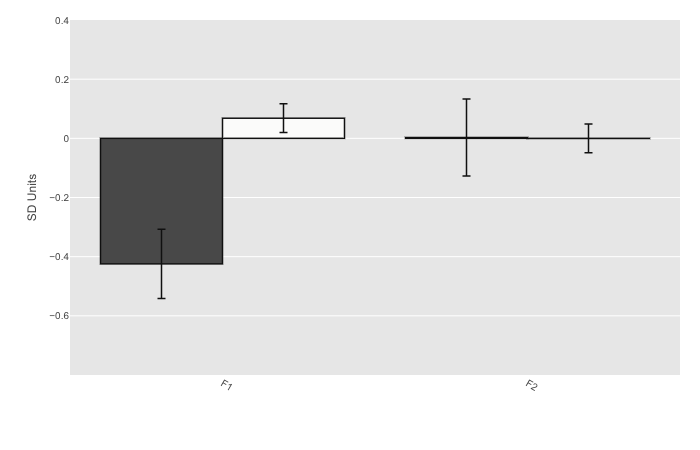

In [36]:
# Compare means of measures that make up F1
import wildpython as wp

hms = sf36vars+subjvars+mhvars+['WHO_COVID_severity']
Zcc['hospital_stay'] = Zcc['hospital_stay'].cat.remove_unused_categories()
Xhm = Zcc.loc[:, hms+['hospital_stay']]
Xhm['WHO_COVID_severity'] = Xhm['WHO_COVID_severity'].apply(lambda x: 6-x)
Xhm['baseline_functioning'] = Xhm['baseline_functioning'].cat.codes
Xhm = Xhm[(Xhm[sf36vars+mhvars+['subjective_memory', 'WHO_COVID_severity']] >= 0).all(axis=1)]

HMtfm = ColumnTransformer([
	('sf36vars', MinMaxScaler(feature_range=[0,1]), sf36vars),
	('subjmem',  MinMaxScaler(feature_range=[0,1]), ['subjective_memory']),
	('mhvars', MinMaxScaler(feature_range=[0,1]), mhvars),
	('bf', 'passthrough', ['baseline_functioning']),
	('WHO', MinMaxScaler(feature_range=[0,1]), ['WHO_COVID_severity'])
]).fit(Xhm[hms])

Xhm = Xhm[['hospital_stay']].join(
	pd.DataFrame(
		HMtfm.transform(Xhm[hms]), 
		index=Xhm.index, columns=wsk.get_ct_feature_names(HMtfm)))

f, m = wp.means_plot(
	Xhm, hms, 'measure', group='hospital_stay', group_order=['Yes', 'No'],
	group_color_sequence=wc.to_RGB_255(bwmap([0.33, 1.0])),
	bar_args={'range_y': [0, 1]}, 
	layout_args={
		'xaxis': {'title': None},
		'yaxis': {'title': 'Normalized Units'},
		'width': 650, 'height': 350},
	group_tests=True)

f.show(rendere='png')

bar_args = {
	'range_y': [-0.8, 0.4],
	'labels': {'mean': 'SD Units'},
}

layout_args = {
	'xaxis': {
		'title': None, 
	},
	'yaxis': {
		'tickmode': 'array',
		'tickvals': np.arange(-0.6, 1.3, 0.2).round(1)
	},
	'width': 400, 'height': 275,
	'margin': {'l': 70, 'b': 75, 't': 20, 'r': 20},
	'legend': {
		'title': "Hospital", 'orientation': 'v',
		'yanchor': 'top', 'xanchor': 'left', 'x': 1.02, 'y': 1.0,
	},
}

grayscale_map = wc.to_RGB_255(bwmap([0.33, 1.0]))

f5a, m = wp.means_plot(
	Zcc, comp_scores, 'measure', group='hospital_stay', group_order=['Yes', 'No'],
	group_color_sequence=grayscale_map,
	bar_args=bar_args, layout_args=layout_args,
)

f5a.show(renderer='png')

layout_args['showlegend'] = False
layout_args['width'] = 200
layout_args['xaxis']['tickangle'] = 30
f5b, m = wp.means_plot(
	Zcc, fnames, 'measure', group='hospital_stay', group_order=['Yes', 'No'],
	group_color_sequence=grayscale_map,
	bar_args=bar_args, layout_args=layout_args,
)
f5b.show(renderer='png')

if True:
	f5a.write_image('./images/Figure_5a.svg')
	f5b.write_image('./images/Figure_5b.svg')


In [37]:
# Compare Hospitalised Groups (T-Tests)
r5a_ttests = (ws
	.two_sample_ttests('hospital_stay', comp_scores+fnames, Zcc, n_comparisons=7)
	.droplevel('contrast')
	.rename(columns={'cohen-d': 'd'})
)

if True:
	write_df_to_html(r5a_ttests[ttest_columns], 'Table_S7')

styled_df(r5a_ttests[ttest_columns])


,diff,tstat,df,p_adj,CI,BF10
score,,,,,,
STM,-0.185016,-1.58,86.98,0.819,"(-0.507, 0.137)",0.47
reasoning,0.332457,2.52,86.86,0.094,"(-0.030, 0.695)",2.88
verbal,0.108738,0.95,95.71,1.000,"(-0.205, 0.423)",0.22
processing_speed,0.301019,2.24,83.33,0.195,"(-0.070, 0.672)",1.52
overall,0.135492,1.08,83.39,1.000,"(-0.211, 0.482)",0.25
F1,0.492390,3.89,90.27,0.001,"(0.144, 0.841)",170.87
F2,-0.003311,-0.02,85.49,1.000,"(-0.385, 0.379)",0.14


In [38]:
# Difference from Controls from Non-/Hospitalised Groups
r5b_ttests = {}
for grp, grp_data in Zcc.groupby('hospital_stay'):
	Zall = pd.concat([grp_data, Zctrl], keys=['CC', 'SS'], names=['study'])
	r5b_ttests[grp] = (ws
		.two_sample_ttests('study', comp_scores, Zall, n_comparisons=10)
		.droplevel('contrast')
		.rename(columns={'cohen-d': 'd'})
	)
r5b_ttests = pd.concat(r5b_ttests.values(), axis=0, keys=r5b_ttests.keys(), names=['hospital_stay'])

if write_tables:
	write_df_to_html(r5b_ttests[ttest_columns], 'Table_S9')

styled_df(r5b_ttests[ttest_columns])


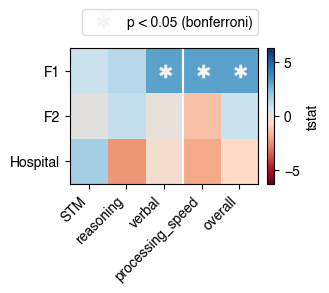

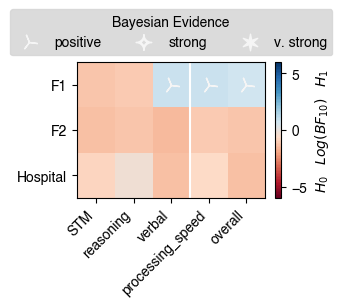

In [39]:
# INCLUDE HOSPITALIZATION IN REGRESSION MODELS
Zcc['hospital_stay'] = OneHotEncoder(drop=['No']).fit_transform(Zcc[['hospital_stay']]).todense()

r4_regressions, _ = ws.regression_analyses(
	'%s ~ F1 + F2 + hospital_stay', 
	comp_scores, Zcc, n_comparisons=15)

r4_comparisons = ws.compare_models([
	{'name': 'F1',
		'h0': '%s ~ 1 + F2 + hospital_stay', 
		'h1': '%s ~ 1 + F1 + F2 + hospital_stay'}, 
	{'name': 'F2',
		'h0': '%s ~ 1 + F1 + hospital_stay', 
		'h1': '%s ~ 1 + F1 + F2 + hospital_stay'},
	{'name': 'hospital_stay',
		'h0': '%s ~ 1 + F1 + F2', 
		'h1': '%s ~ 1 + F1 + F2 + hospital_stay'},],
	Zcc, comp_scores, smf.ols, n_comparisons=15)

res4_ = (r4_regressions
	.join(r4_comparisons.loc[:, comp_columns])
	.rename(columns={'value': 'B'})
	.loc[r4_regressions.index, column_order]
	.drop('Intercept', level='contrast')
	.rename({'hospital_stay': 'Hospital'})
)

r4_t_fig = wp.create_stats_figure(
	res4_, 'tstat', 'p_adj', stat_range=[-6.3, 6.3],
	vertline=2, diverging=True, correction=adj)
r4_b_fig = wp.create_bayes_factors_figure(
	res4_, suppress_h0=True, vertline=2)

if False:
	write_df_to_html(res4_[column_order], 'Table_S9')

if False: # REDO
	r4_t_fig.savefig('../images/Figure_7a.svg')
	r4_b_fig.savefig('../images/Figure_7b.svg')


 ## Other Exploratory Analyses

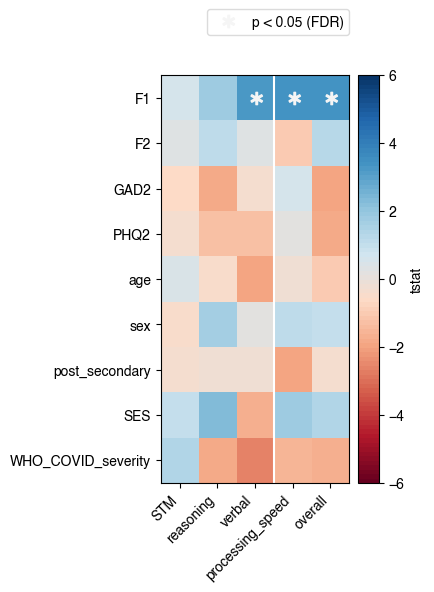

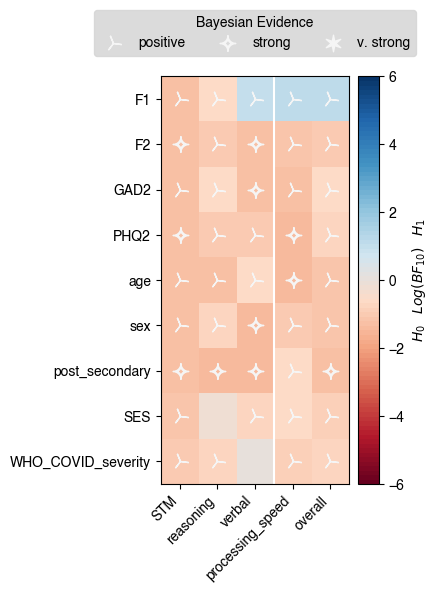

In [40]:

vars_ = fnames+mhvars+Xcovar+['WHO_COVID_severity']#+sf36vars

r5_regressions = [ws.regression_analyses(f"%s ~ {v}", comp_scores, Zcc) for v in vars_]
r5_regressions = [r[0].drop('Intercept', level='contrast') for r in r5_regressions]
r5_regressions = pd.concat(r5_regressions, axis=0)
r5_regressions = ws.adjust_pvals(
	r5_regressions, adj_across='all', adj_type='fdr_bh')

models = [{'name': v, 'h0': f"%s ~ 1", 'h1': f"%s ~ {v}"} for v in vars_]
r5_comparisons = ws.compare_models(models, Zcc, comp_scores, smf.ols)

f5_ts = wp.create_stats_figure(
	r5_regressions, 'tstat', 'p_adj', diverging=True, vertline=2, 
	correction='FDR', stat_range=[-6, 6])
f5_bf = wp.create_bayes_factors_figure(r5_comparisons, 
	vertline=2, cell_scale=0.6)

if False:
	f5_ts.savefig('../images/Figure_S3a.svg')
	f5_bf.savefig('../images/Figure_S3b.svg')


In [41]:
# QQ-PLOTS OF SCORES, BY HOSPITALISATION
qq = np.empty([len(comp_scores), 2], dtype='object')
qt = np.empty([len(comp_scores), 2], dtype='object')
for ir, score in enumerate(comp_scores):
	for ic, grp in enumerate(["Yes", "No"]):
		xx = Zcc_.loc[Zcc_.hospital_stay==grp, score]
		qq[ir, ic] = probplot(xx, dist="norm")
		qt[ir, ic] = f"{score} (Hospital = {grp})"

qq_hosp = wp.qq_plots(qq, qt, layout_args={
	'height': 800, 'width': 500
})
iplot(qq_hosp)

if False:
	qq_hosp.write_image('../images/qq_hosp.svg')


NameError: name 'iplot' is not defined

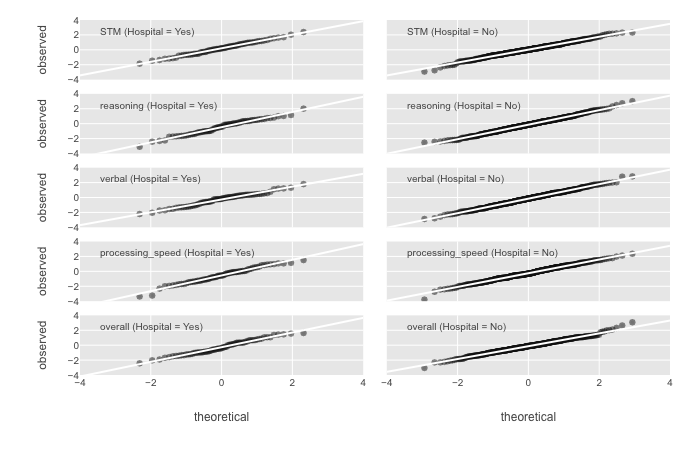

In [42]:
# QQ-PLOTS OF SCORES, BY HOSPITALISATION
qq = np.empty([len(comp_scores), 2], dtype='object')
qt = np.empty([len(comp_scores), 2], dtype='object')
for ir, score in enumerate(comp_scores):
	for ic, grp in enumerate(["Yes", "No"]):
		xx = Zcc_.loc[Zcc_.hospital_stay==grp, score]
		qq[ir, ic] = probplot(xx, dist="norm")
		qt[ir, ic] = f"{score} (Hospital = {grp})"

qq_hosp = wp.qq_plots(qq, qt, layout_args={
	'height': 800, 'width': 500
})
qq_hosp.show(renderer='png')

if False:
	qq_hosp.write_image('../images/qq_hosp.svg')


 ## Sankey Diagram
 - This needs to be cleaned up.

In [44]:

import itertools

groupers = ['symptoms',
			'hospital_stay', 'supplemental_O2_hospital',
			'ICU_stay',
			'ventilator', 'daily_routine', 'WHO']

q2 = Qcc.loc[Zcc.index, groupers].copy()
q2['WHO'] = q2['WHO'].cat.add_categories('NA')
q2 = q2.fillna('NA')
q2.symptoms = q2.symptoms.astype('category')

q2 = remove_unused_categories(q2)

opts = [list(q2[g].cat.categories) for g in groupers]

all_paths = list(itertools.product(*opts))

src = []
trg = []
cnt = []
lab = []
for i, p in enumerate(all_paths):
	cnt.append((q2[groupers] == p).all(axis=1).sum())

good_i = [i for i, count in enumerate(cnt) if count > 0]
good_paths = [all_paths[i] for i in good_i]

p_ = []
for p in good_paths:
	lab.append(q2[(q2[groupers] == p).all(axis=1)]['WHO'].describe().top)
	p_.append(q2[(q2[groupers] == p).all(axis=1)])

good_cnts = [cnt[i] for i in good_i]

cats = CC.questionnaire.WHO_cats
ncat = len(cats)

nodes = [f"{groupers[i]}_{o}" for i,
		 opt in enumerate(opts) for o in opt if o != "NA"]

node_dict = dict(zip(nodes,[
 '[N] symptoms',
 '[Y] symptoms',
 '[N] hospital',
 '[Y] hospital',
 '[?] supplemental_O2',
 '[N] supplemental_O2',
 '[Y] supplemental_O2',
 '[N] ICU',
 '[Y] ICU',
 '[N] ventilator',
 '[Y] ventilator',
 '[N] daily_routine',
 '[Y] daily_routine',
 'WHO 0',
 'WHO 1',
 'WHO 2',
 'WHO 3',
 'WHO 4',
 'WHO 5',
 'WHO 6']))

node_vals = list(node_dict.keys())
node_keys = list(node_dict.values())

l = {'source': [], 'target': [], 'value': [], 'color': [], 'label': []}
ll = {'source': [], 'target': [], 'value': []}
j = 0
for j, p in enumerate(good_paths):
	for i,v in enumerate(p[:-1]):
		if p[i] != "NA":
			ti = i+1
			while ti < (len(p)-1) and p[ti] == "NA":
				ti += 1
			if p[ti] != "NA":
				src = f"{groupers[i]}_{p[i]}"
				trg = f"{groupers[ti]}_{p[ti]}"
				l['source'].append(node_vals.index(src))
				l['target'].append(node_vals.index(trg))
				l['label'].append(lab[j])
				l['value'].append(good_cnts[j])
				ll['source'].append(src)
				ll['target'].append(trg)
				ll['value'].append(good_cnts[j])

from floweaver import *

cats = CC.questionnaire.WHO_cats
ncat = len(cats)

import matplotlib
colormap = matplotlib.colors.ListedColormap(plotly.colors.sequential.Plasma)
colors = colormap(np.linspace(0, 1, ncat))
colors[:, -1] = 0.1

colors = [matplotlib.colors.to_hex(c) for c in colors]
colormap = dict(zip(cats, colors[0:ncat]))

ll = pd.DataFrame(good_paths, columns=groupers)
ll['value'] = good_cnts
ll = ll.rename(columns={'symptoms': 'source', 'WHO': 'target'})
ll[ll=='NA'] = np.nan
ll

target = Partition.Simple('target', CC.questionnaire.WHO_cats)

nodes = {
	'start': ProcessGroup([False, True], Partition.Simple('source', [False, True]), title='Symptoms'),
	'end': ProcessGroup(CC.questionnaire.WHO_cats, target, title='COVID Severity'),
	'hospital': Waypoint(Partition.Simple('hospital_stay', ['No', 'Yes']), title='Hospitalised'),
	'daily': Waypoint(Partition.Simple('daily_routine', ['Yes', 'No']), title='Functional'),
	'o2': Waypoint(Partition.Simple('supplemental_O2_hospital', ['No', 'Yes', "Don't Know"]), title='Supplemental O2'),
	'ICU': Waypoint(Partition.Simple('ICU_stay', ['No', 'Yes']), title='ICU'),
	'ventilator': Waypoint(Partition.Simple('ventilator', ['No', 'Yes']), title='Ventilator'),
}

order = [
	['start'],
	['hospital'],
	['o2'],
	['daily', 'ICU'],
	['ventilator'],
	['end']
]

bundles = [
	# Bundle('start', 'end', waypoints=['hospital', 'ICU'], flow_selection="(hospital_stay == 'Yes')"),
	Bundle('start', 'end', waypoints=['hospital', 'daily'], flow_selection="(hospital_stay == 'No')"),
	Bundle('start', 'end', waypoints=['hospital', 'o2', 'ICU', 'ventilator'], flow_selection="(ICU_stay == 'Yes')"),
	Bundle('start', 'end', waypoints=['hospital', 'o2', 'ICU'], flow_selection="(ICU_stay == 'No')"),
]

sdd = SankeyDefinition(nodes, bundles, order, flow_partition=target)
weave(sdd, ll, palette=colormap).to_widget(width=1000, align_link_types=True).auto_save_svg('./images/sankey.svg')



/Users/conorwild/.virtualenvs/cbspython/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/conorwild/.virtualenvs/cbspython/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



SankeyWidget(align_link_types=True, groups=[{'id': 'start', 'type': 'process', 'title': 'Symptoms', 'nodes': […